In [1]:
import cv2 as cv2
import numpy as np
import pickle 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras as kr
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
img_height = 128
img_width = 128
filters = [32,32,32]


In [4]:

batch_size = 32

train_ds = kr.utils.image_dataset_from_directory(
    "Covid19-dataset/train",
    seed = 123,
    image_size = (img_height,img_width)
)
test_ds = kr.utils.image_dataset_from_directory(
    "Covid19-dataset/test",
    seed = 123,
    image_size = (img_height,img_width)
)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


In [5]:
class_names = train_ds.class_names
class_names

['Covid', 'Normal', 'Viral Pneumonia']

In [6]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  class_2 = labels == 2
  class_2 = tf.cast(class_0, tf.int32)
  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)
  counts['class_2'] += tf.reduce_sum(class_2)

  return counts

counts = train_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0, 'class_2' : 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy(),
                   counts['class_2'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.380137   0.23972602 0.380137  ]


In [7]:
def class_func(features, label):
  return label

In [8]:
resample_ds = (
    train_ds
    .unbatch()
    .rejection_resample(class_func, target_dist=[0.33,0.33,0.33],
                        initial_dist=fractions)
    .batch(32))

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [9]:
balanced_train_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [29]:
from keras.layers import Rescaling,Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Input
num_classes = 3
f = 4
n = 16
s =  3
model = tf.keras.Sequential([
    Rescaling(1./255),
    Conv2D(f,s,activation = "relu"),
    MaxPooling2D(),
    Conv2D(f,s,activation = "relu"),
    MaxPooling2D(),
    Conv2D(f,s,activation = "relu"),
    MaxPooling2D(),
    Conv2D(f,s,activation = "relu"),
    MaxPooling2D(),

    Flatten(),
    Dense(n,activation = 'relu'),
    Dropout(0.2),
    Dense(num_classes,activation="softmax")
]
)
print("done")

done


In [30]:
optimzer = kr.optimizers.Adam(learning_rate=0.00001)
model.compile(
    optimizer="Adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop],
    shuffle=True
)

Epoch 1/50
8/8 [==============================] - 1s 31ms/step - loss: 1.0922 - accuracy: 0.4183 - val_loss: 1.0868 - val_accuracy: 0.4697
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 1.0713 - accuracy: 0.6972 - val_loss: 1.0587 - val_accuracy: 0.6818
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 1.0220 - accuracy: 0.7729 - val_loss: 1.0118 - val_accuracy: 0.6364
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.9400 - accuracy: 0.8327 - val_loss: 0.9035 - val_accuracy: 0.8182
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.8019 - accuracy: 0.8127 - val_loss: 0.7698 - val_accuracy: 0.8636
Epoch 6/50
8/8 [==============================] - 0s 23ms/step - loss: 0.6111 - accuracy: 0.8805 - val_loss: 0.6185 - val_accuracy: 0.7879
Epoch 7/50
8/8 [==============================] - 0s 22ms/step - loss: 0.4990 - accuracy: 0.8486 - val_loss: 0.4767 - val_accuracy: 0.8030
Epoch 8/50
8/8 [===========

In [12]:
from keras.utils.layer_utils import count_params

In [13]:
neurons = [4,8,16,32,64]
filters = [2,4,6,8,16]
strides = 3

scores = np.zeros((len(neurons),len(filters)))

params = np.zeros((len(neurons),len(filters)))
for i,n in enumerate(neurons):
    for j,f in enumerate(filters):

        model = tf.keras.Sequential([
            Rescaling(1./255),
            Conv2D(f,strides,activation = "relu"),
            MaxPooling2D(),
            Conv2D(f,strides,activation = "relu"),
            MaxPooling2D(),
            Conv2D(f,strides,activation = "relu"),
            MaxPooling2D(),
            Conv2D(f,strides,activation = "relu"),
            MaxPooling2D(),
            Flatten(),
            Dense(n,activation = 'relu'),
            Dropout(0.3),
            Dense(num_classes,activation="softmax")
        ]
        )
        optimzer = kr.optimizers.Adam(learning_rate=0.00001)
        model.compile(
            optimizer="Adam",
            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=["accuracy"]
        )
        early_stop = EarlyStopping(monitor='val_loss', patience=5)
        callback = model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=50,
            callbacks=[early_stop],
            shuffle=True,
            verbose=0
        )



        params[i,j] = count_params(model.trainable_weights)


        scores[i,j] = callback.history['val_accuracy'][-1]
                

KeyboardInterrupt: 

In [65]:
params

array([[  477.,  1151.,  2041.,  3147.,  9731.],
       [  781.,  1743.,  2921.,  4315., 12051.],
       [ 1389.,  2927.,  4681.,  6651., 16691.],
       [ 2605.,  5295.,  8201., 11323., 25971.],
       [ 5037., 10031., 15241., 20667., 44531.]])

In [66]:
scores

array([[0.86363637, 0.74242425, 0.65151513, 0.39393941, 0.80303031],
       [0.71212119, 0.86363637, 0.90909094, 0.86363637, 0.87878788],
       [0.72727275, 0.87878788, 0.87878788, 0.77272725, 0.86363637],
       [0.80303031, 0.93939394, 0.90909094, 0.87878788, 0.83333331],
       [0.78787881, 0.87878788, 0.90909094, 0.89393938, 0.92424244]])

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 126, 4)       112       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 4)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 4)         148       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 4)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 4)        

3/3 [==============================] - 0s 124ms/step


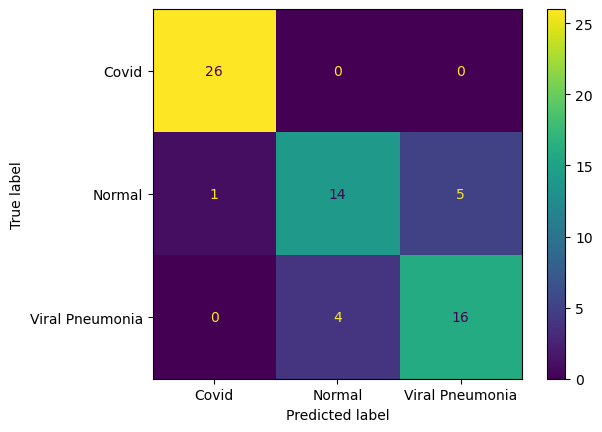

In [31]:


y_pred = np.argmax(model.predict(val_ds),axis=1)

train_label = np.concatenate([y for x, y in val_ds], axis=0)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 

CM = tf.math.confusion_matrix(labels=test_label,predictions=y_pred).numpy()

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cd = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = class_names)
cd.plot()
plt.show()

In [32]:
outputs = [layer.output for layer in model.layers[8:8]]

# Define a new model that generates the above output
vis_model = kr.models.Model(model.input, [model.layers[5].output,model.output])
print(model.layers[3].name)
# check if we have all the layers we require for visualization 
vis_model.summary()

conv2d_21
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5_input (InputLay  [(None, 256, 256, 3)]    0         
 er)                                                             
                                                                 
 rescaling_5 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 254, 254, 4)       112       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 127, 127, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 4)       148       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 62, 62, 4)    

In [83]:
# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
[]


In [86]:
from keras import backend as K
def get_CAM(processed_image, predicted_label):
    with tf.GradientTape() as gtape:
        data = vis_model(processed_image)
        conv_output = data[0]
        print(conv_output.shape)
        predictions = data[1]
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        print(grads.shape)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = np.squeeze(tf.multiply(pooled_grads, conv_output))
    print(f"max before mean : {np.max(heatmap)}")
    heatmap = tf.reduce_mean(np.abs(heatmap), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    return heatmap

def show_random_sample(idx):
    sample = val_ds.unbatch().shuffle(64).take(1)
    image,label = sample.get_single_element()
    image = image.numpy()
    label = label.numpy()
    sample_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample_label = label
    
    # pre-process the image
    sample_image_processed = np.expand_dims(sample_image,axis=0)
    print(sample_image.shape)
    # generate activation maps from the intermediate layers using the visualization model
    activations = vis_model.predict(sample_image_processed)
    # get the label predicted by our original model
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    # choose any random activation map from the activation maps 
    print('acti')
    print(activations[0].shape)
    sample_activation = activations[0][0,:,:,-1]
    
    # normalize the sample activation map
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    # convert pixel values between 0-255
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    
    
    # get the heatmap for class activation map(CAM)
    
    heatmap = get_CAM(sample_image_processed, pred_label)
    print(heatmap.shape)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    print(f"max : {np.max(heatmap)}")
    heatmap = heatmap/np.max(heatmap)*255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    print(heatmap.shape)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_image = heatmap * 0.5 + sample_image
    super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)

    f,ax = plt.subplots(2,2, figsize=(15,8))
    ax[0,0].imshow(sample_image/255)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.show()
    
    return activations

(128, 128, 3)
1/1 [==============================] - 0s 13ms/step
acti
(1, 28, 28, 4)
(1, 28, 28, 4)
(1, 28, 28, 4)
max before mean : 0.0023635851684957743
(28, 28)
max : 0.001075998181477189
(128, 128)


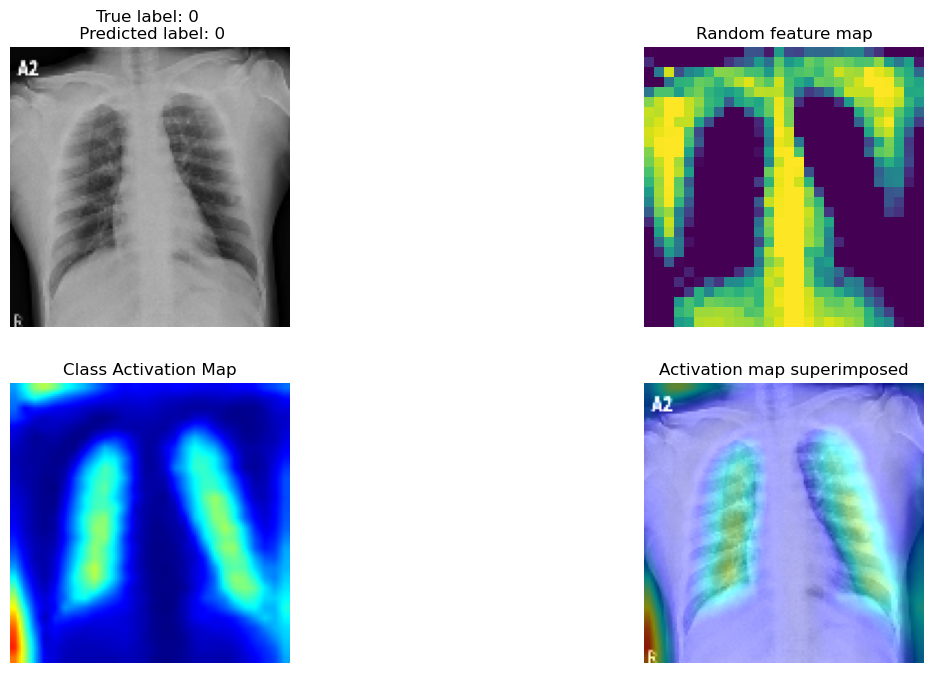

In [87]:
activations= show_random_sample(123)

In [89]:
def visualize_intermediate_activations(layer_names, activations):
    """
    This function is used to visualize all the itermediate activation maps
    
    Arguments:
        layer_names: list of names of all the intermediate layers we chose
        activations: all the intermediate activation maps 
    """
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=2
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size * 6
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

https://www.elsevier.es/en-revista-radiologia-english-edition--419-articulo-radiologic-diagnosis-patients-with-covid-19-S2173510721000033

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8553512/
https://www.bmj.com/content/370/bmj.m2426

![](https://www.bmj.com/content/bmj/370/bmj.m2426/F2.large.jpg?width=800&height=600)

![](https://www.bmj.com/content/bmj/370/bmj.m2426/F3.large.jpg?width=800&height=600)

C:\Users\PC\AppData\Local\Temp\ipykernel_9824\1659934554.py:23: RuntimeWarning: invalid value encountered in true_divide
  feature_map /= feature_map.std()


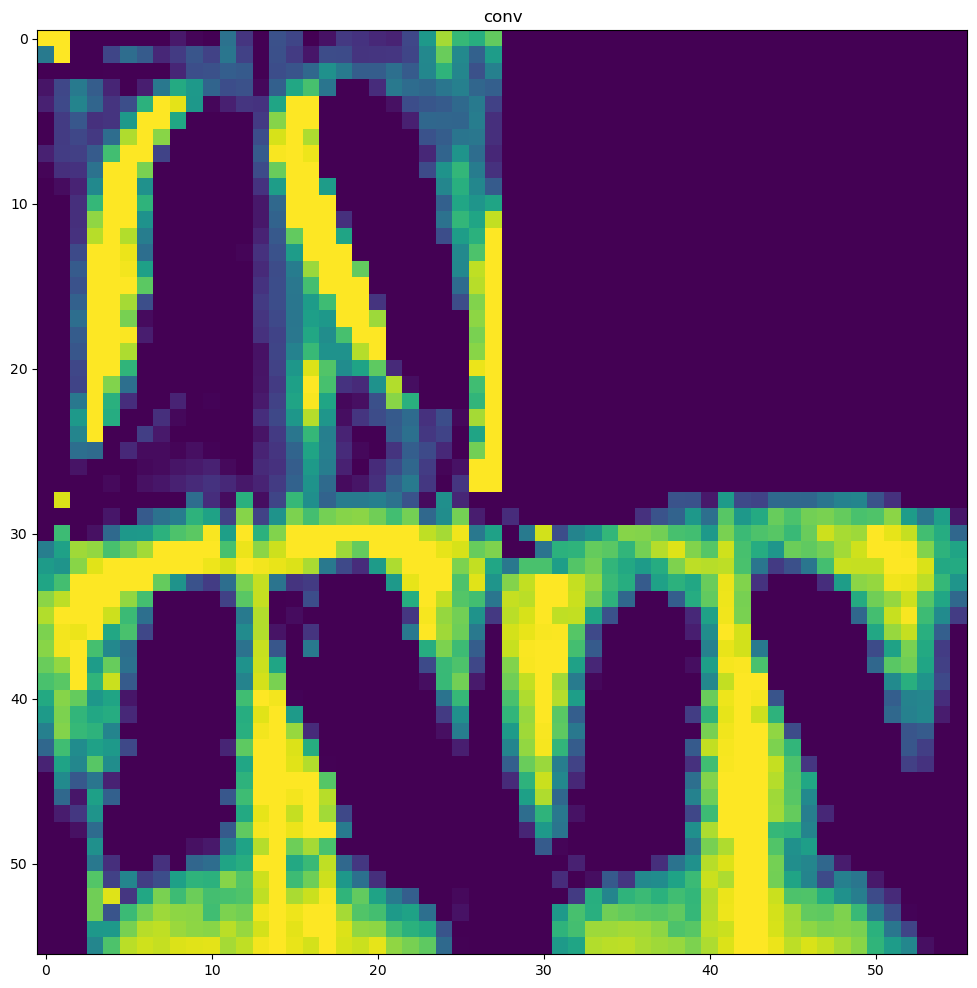

In [90]:
visualize_intermediate_activations(["conv"], activations[0])